In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm
from tqdm import tqdm
from multiprocessing.dummy import Pool
import statsmodels.formula.api as smf
pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

In [2]:
crsp_df = pd.read_csv("crsp.zip", compression='zip',header=0,
             parse_dates = ['date','DCLRDT','RCRDDT'],
             dtype={"PRC": np.float64,
                  "VOL": np.float64,
                  "SHROUT": np.float64,
                  "DIVAMT": np.float64,
                  "SPREAD": np.float64,
                  "SHRCD":str,
                  "DISTCD":str,
                  "COMNAM": str,
                  "TICKER": str,
                   'CUSIP': str})
#Data Preprocessing
crsp_df = crsp_df[(crsp_df.SHRCD.isin(('10','11')))]
crsp_df = crsp_df[(crsp_df.date >= '1927-01-01')]
crsp_df = crsp_df[(crsp_df.date <= '2011-12-31')]
cusips_DISTCD_12 = crsp_df[crsp_df.DISTCD.apply(lambda x: x[:2]=='12' if isinstance(x, str) else False)].CUSIP.unique()
crsp_df = crsp_df[crsp_df.CUSIP.isin(cusips_DISTCD_12)]

crsp_df.PRC = crsp_df.PRC.abs()


crsp_df['year'] = crsp_df['date'].dt.year
crsp_df['month'] = crsp_df['date'].dt.month
crsp_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_df['PRC_t-1'] = crsp_df.groupby('CUSIP')['PRC'].shift(1)
crsp_df.head()


,PERMNO,date,SHRCD,TICKER,COMNAM,CUSIP,DCLRDT,RCRDDT,DISTCD,DIVAMT,PRC,VOL,RET,SHROUT,SPREAD,RETX,year,month,PRC_t-1
1359100,25881,1970-11-30,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.000,318.0,C,2655.0,NaN,C,1970,11,NaN
1359101,25881,1970-12-31,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,10.000,646.0,0.111111,2655.0,NaN,0.111111,1970,12,9.000
1359102,25881,1971-01-29,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.000,636.0,-0.100000,2655.0,NaN,-0.100000,1971,1,10.000
1359103,25881,1971-02-26,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,11.125,2155.0,0.236111,2655.0,NaN,0.236111,1971,2,9.000
1359104,25881,1971-03-31,10,AE,A & E PLASTIK PAK INC,00003210,NaT,NaT,NaN,NaN,9.750,2062.0,-0.123596,2655.0,NaN,-0.123596,1971,3,11.125


In [3]:
crsp_div_df = crsp_df[['date','CUSIP','DCLRDT','RCRDDT','DISTCD','DIVAMT','PRC','PRC_t-1','RET','SHROUT','month', 'VOL']].copy()
crsp_div_df 
# crsp_div_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_div_df = crsp_div_df.groupby(by=['CUSIP','date']).agg({
     'DCLRDT': 'last',
     'RCRDDT': 'last',
     'DISTCD': 'last',
     'DIVAMT': 'last',
     'RET':'last',
     'PRC': 'last',
     'PRC_t-1': 'last',
     'SHROUT': 'last',
     'VOL': 'last'})
# crsp_div_df.sort_values(by=['CUSIP','date'], ascending=True, inplace=True)
crsp_div_df['freq'] = None
crsp_div_df['freq'] = crsp_div_df[crsp_div_df.RCRDDT.isna()==False]['DISTCD'].apply(lambda x: x[2:3] if x is not None else None)

# fil_C = (crsp_div_df["PRC_t-1"] >= 5) & (crsp_div_df.freq < '6')
# crsp_div_df = crsp_div_df[fil_C]

crsp_div_df['MCAP'] = crsp_div_df['PRC'] * crsp_div_df['SHROUT']
crsp_div_df['TURNOVER'] = crsp_div_df['VOL'] / crsp_div_df['SHROUT']
crsp_div_df['TURNOVER_t-1'] = crsp_div_df.groupby('CUSIP')['TURNOVER'].shift(1)
crsp_div_df['div_yield'] = crsp_div_df['DIVAMT'].apply(lambda x: 0.0 if pd.isna(x) else x)
crsp_div_df['div_yield'] = list(np.around(crsp_div_df.groupby(by=['CUSIP'])['div_yield'].rolling(window=12, min_periods=0).sum(),decimals=5))
crsp_div_df['div_yield'] = crsp_div_df['div_yield']/crsp_div_df['PRC']
# crsp_div_df.loc[crsp_div_df['freq'].isna(),'div_yield'] = np.nan
crsp_div_df['div_yield_t-1'] = crsp_div_df.groupby('CUSIP')['div_yield'].shift(1)
crsp_div_df

DCLRDT RCRDDT DISTCD  DIVAMT        RET     PRC  PRC_t-1  \
CUSIP    date                                                                  
00003210 1970-11-30    NaT    NaT   None     NaN          C   9.000      NaN   
         1970-12-31    NaT    NaT   None     NaN   0.111111  10.000    9.000   
         1971-01-29    NaT    NaT   None     NaN  -0.100000   9.000   10.000   
         1971-02-26    NaT    NaT   None     NaN   0.236111  11.125    9.000   
         1971-03-31    NaT    NaT   None     NaN  -0.123596   9.750   11.125   
...                    ...    ...    ...     ...        ...     ...      ...   
N5946510 2011-08-31    NaT    NaT   None     NaN  -0.089113  20.750   22.780   
         2011-09-30    NaT    NaT   None     NaN  -0.181205  16.990   20.750   
         2011-10-31    NaT    NaT   None     NaN   0.151854  19.570   16.990   
         2011-11-30    NaT    NaT   None     NaN  -0.002044  19.530   19.570   
         2011-12-30    NaT    NaT   None     NaN   0.098822  21.460   19.530   

                       SHROUT        VOL freq         MCAP  TURNOVER  \
CUSIP    date                                                          
00003210 1970-11-30    2655.0      318.0  NaN    23895.000  0.119774   
         1970-12-31    2655.0      646.0  NaN    26550.000  0.243315   
         1971-01-29    2655.0      636.0  NaN    23895.000  0.239548   
         1971-02-26    2655.0     2155.0  NaN    29536.875  0.811676   
         1971-03-31    2655.0     2062.0  NaN    25886.250  0.776648   
...                       ...        ...  ...          ...       ...   
N5946510 2011-08-31  426263.0  2419635.0  NaN  8844957.250  5.676390   
         2011-09-30  426485.0  1672860.0  NaN  7245980.150  3.922436   
         2011-10-31  426512.0  1538552.0  NaN  8346839.840  3.607289   
         2011-11-30  426512.0  1220142.0  NaN  8329779.360  2.860745   
         2011-12-30  426678.0  1185432.0  NaN  9156509.880  2.778282   

                     TURNOVER_t-1  div_yield  div_yield_t-1  
CUSIP    date                                                
00003210 1970-11-30           NaN        0.0            NaN  
         1970-12-31      0.119774        0.0            0.0  
         1971-01-29      0.243315        0.0            0.0  
         1971-02-26      0.239548        0.0            0.0  
         1971-03-31      0.811676        0.0            0.0  
...                           ...        ...            ...  
N5946510 2011-08-31      2.496675       -0.0           -0.0  
         2011-09-30      5.676390       -0.0           -0.0  
         2011-10-31      3.922436       -0.0           -0.0  
         2011-11-30      3.607289       -0.0           -0.0  
         2011-12-30      2.860745       -0.0           -0.0  

[2097733 rows x 15 columns]

In [4]:
crsp_div_df['div_yr']= crsp_div_df['freq']=='6'
crsp_div_df['div_semi_annual']= crsp_div_df['freq']=='4'
crsp_div_df['div_quarterly']= crsp_div_df['freq']=='3'
crsp_div_df['div_unknown']= crsp_div_df['freq'].isin(['0','1'])
crsp_div_df['div_monthly']= crsp_div_df['freq']=='2'

crsp_temp=crsp_div_df
crsp_temp['freq_2'] = crsp_temp['freq'].groupby(by=['CUSIP']).fillna(method='ffill', limit=11)


In [5]:
g = crsp_temp.groupby('CUSIP')['div_unknown']
crsp_temp['lag_u_1']=g.shift(1)
crsp_temp['lag_u_2']=g.shift(2)
crsp_temp['lag_u_3']=g.shift(3)
crsp_temp['lag_u_4']=g.shift(4)
crsp_temp['lag_u_5']=g.shift(5)
crsp_temp['lag_u_6']=g.shift(6)
crsp_temp['lag_u_7']=g.shift(7)
crsp_temp['lag_u_8']=g.shift(8)
crsp_temp['lag_u_9']=g.shift(9)
crsp_temp['lag_u_10']=g.shift(10)
crsp_temp['lag_u_11']=g.shift(11)
crsp_temp['lag_u_12']=g.shift(12)


crsp_temp['lag_quarterly']=crsp_temp.groupby('CUSIP')['div_quarterly'].shift(3)
crsp_temp['lag_semi_annual_six']=crsp_temp.groupby('CUSIP')['div_semi_annual'].shift(6)
crsp_temp['lag_semi_annual_twl']=crsp_temp.groupby('CUSIP')['div_semi_annual'].shift(12)
crsp_temp['lag_div_yr']=crsp_temp.groupby('CUSIP')['div_yr'].shift(12)

g_mon = crsp_temp.groupby('CUSIP')['div_monthly']
crsp_temp['lag_1']=g_mon.shift(1)
crsp_temp['lag_4']=g_mon.shift(4)
crsp_temp['lag_7']=g_mon.shift(7)
crsp_temp['lag_10']=g_mon.shift(10)

crsp_div_df['lag_month']=g_mon.shift(1)

crsp_temp.head()

DCLRDT RCRDDT DISTCD  DIVAMT        RET     PRC  PRC_t-1  \
CUSIP    date                                                                  
00003210 1970-11-30    NaT    NaT   None     NaN          C   9.000      NaN   
         1970-12-31    NaT    NaT   None     NaN   0.111111  10.000    9.000   
         1971-01-29    NaT    NaT   None     NaN  -0.100000   9.000   10.000   
         1971-02-26    NaT    NaT   None     NaN   0.236111  11.125    9.000   
         1971-03-31    NaT    NaT   None     NaN  -0.123596   9.750   11.125   

                     SHROUT     VOL freq  ...  lag_u_12  lag_quarterly  \
CUSIP    date                             ...                            
00003210 1970-11-30  2655.0   318.0  NaN  ...       NaN            NaN   
         1970-12-31  2655.0   646.0  NaN  ...       NaN            NaN   
         1971-01-29  2655.0   636.0  NaN  ...       NaN            NaN   
         1971-02-26  2655.0  2155.0  NaN  ...       NaN          False   
         1971-03-31  2655.0  2062.0  NaN  ...       NaN          False   

                     lag_semi_annual_six  lag_semi_annual_twl  lag_div_yr  \
CUSIP    date                                                               
00003210 1970-11-30                  NaN                  NaN         NaN   
         1970-12-31                  NaN                  NaN         NaN   
         1971-01-29                  NaN                  NaN         NaN   
         1971-02-26                  NaN                  NaN         NaN   
         1971-03-31                  NaN                  NaN         NaN   

                     lag_1  lag_4  lag_7  lag_10  lag_month  
CUSIP    date                                                
00003210 1970-11-30    NaN    NaN    NaN     NaN        NaN  
         1970-12-31  False    NaN    NaN     NaN      False  
         1971-01-29  False    NaN    NaN     NaN      False  
         1971-02-26  False    NaN    NaN     NaN      False  
         1971-03-31  False  False    NaN     NaN      False  

[5 rows x 42 columns]

In [34]:
# Strategies 1: Long predicted dividend and short all other companies
crsp_temp['long_stocks'] = (  crsp_temp['lag_quarterly'] | crsp_temp['lag_semi_annual_six'] | crsp_temp['lag_semi_annual_twl'] | crsp_temp['lag_div_yr']) & (crsp_temp['PRC_t-1'] >=5)
# (crsp_temp['div_yield_t-1'] >= 0.01)

crsp_temp.RET = crsp_temp.RET.apply(lambda x: x if str(x)[-1].isdigit() else np.nan)
crsp_temp['RET'] = crsp_temp['RET'].astype('float64')
crsp_temp
crsp_temp['short_stocks'] = (crsp_temp['long_stocks'] == False) & (crsp_temp['PRC_t-1'] >=5) & (crsp_temp['freq_2'] < '6')




In [35]:
# crsp_temp['short_stocks'].groupby('date').sum()
crsp_temp.head()

DCLRDT RCRDDT DISTCD  DIVAMT       RET     PRC  PRC_t-1  \
CUSIP    date                                                                 
00003210 1970-11-30    NaT    NaT   None     NaN       NaN   9.000      NaN   
         1970-12-31    NaT    NaT   None     NaN  0.111111  10.000    9.000   
         1971-01-29    NaT    NaT   None     NaN -0.100000   9.000   10.000   
         1971-02-26    NaT    NaT   None     NaN  0.236111  11.125    9.000   
         1971-03-31    NaT    NaT   None     NaN -0.123596   9.750   11.125   

                     SHROUT     VOL  freq  ...  lag_7  lag_10  lag_month  \
CUSIP    date                              ...                             
00003210 1970-11-30  2655.0   318.0  None  ...    NaN     NaN        NaN   
         1970-12-31  2655.0   646.0  None  ...    NaN     NaN      False   
         1971-01-29  2655.0   636.0  None  ...    NaN     NaN      False   
         1971-02-26  2655.0  2155.0  None  ...    NaN     NaN      False   
         1971-03-31  2655.0  2062.0  None  ...    NaN     NaN      False   

                     long_stocks  short_stocks   MCAP_t-1  long_weight  \
CUSIP    date                                                            
00003210 1970-11-30        False         False        NaN          NaN   
         1970-12-31        False         False  23895.000          NaN   
         1971-01-29        False         False  26550.000          NaN   
         1971-02-26        False         False  23895.000          NaN   
         1971-03-31        False         False  29536.875          NaN   

                     short_weight  port_return_long_vw  port_return_short_vw  
CUSIP    date                                                                 
00003210 1970-11-30           NaN                  NaN                   NaN  
         1970-12-31           NaN                  NaN                   NaN  
         1971-01-29           NaN                  NaN                   NaN  
         1971-02-26           NaN                  NaN                   NaN  
         1971-03-31           NaN                  NaN                   NaN  

[5 rows x 49 columns]

In [36]:
def long_short_weights(group):
    group['long_weight'] = np.nan
    longs = group.loc[group['long_stocks'] == True]
    group.loc[group['long_stocks']==True, 'long_weight'] = longs['MCAP_t-1'].groupby('date').apply(lambda x: x/ x.sum())
    # group['long_weight'] = group['long_weight'].groupby('CUSIP').shift(1)

    group['short_weight'] = np.nan
    # fil_short = group['long_stocks'] == False
    fil_short = group.short_stocks
    shorts = group.loc[fil_short]
    group.loc[fil_short, 'short_weight'] = shorts['MCAP_t-1'].groupby('date').apply(lambda x: x/ x.sum())
    # group['short_weight'] = group['short_weight'].groupby('CUSIP').shift(1)
    return group

def cal_return_vw(df):

    df['port_return_long_vw'] = df['RET'] * df['long_weight']
    longport = df['port_return_long_vw'].groupby('date').sum()

    df['port_return_short_vw'] = df['RET'] * df['short_weight']
    shortport = df['port_return_short_vw'].groupby('date').sum()

    data=pd.merge(longport, shortport, on='date', suffixes=['_long', '_short'])
    data['longshort_vw'] = data.port_return_long_vw  - data.port_return_short_vw
    data['cum_vw'] = (data.longshort_vw + 1).cumprod()

    return longport,shortport,data

def cal_return_eq(group):
    #Kobe Updated part, 
    longs = group.loc[group['long_stocks'] == True]
    longport = longs.RET.groupby('date').mean() 

    # fil_short = group['long_stocks'] == False
    fil_short = group.short_stocks
    shorts = group.loc[fil_short]
    shortport = shorts.RET.groupby('date').mean()
    
    data=pd.merge(longport, shortport, on='date', suffixes=['_long', '_short'])
    data['longshort_eq'] = data.RET_long  - data.RET_short
    data['cum_ew'] = (data.longshort_eq + 1).cumprod()
    # print(data)
    # print(shortport)
    # print(longshortport)
    
    return longport,shortport,data

crsp_temp['MCAP_t-1'] = crsp_temp.MCAP.groupby('CUSIP').shift(1)
# crsp_temp2 =
panel=long_short_weights(crsp_temp)
longport_vw,shortport_vw,longshortport_vw=cal_return_vw(panel)
longport_eq,shortport_eq,longshortport_eq=cal_return_eq(crsp_temp)

crsp_temp.RET = crsp_temp.RET.apply(lambda x: x if str(x)[-1].isdigit() else np.nan)
crsp_temp['RET'] = crsp_temp['RET'].astype('float64')

crsp_temp['long_stocks'] = (  crsp_temp['lag_quarterly'] | crsp_temp['lag_semi_annual_six'] | crsp_temp['lag_semi_annual_twl'] | crsp_temp['lag_div_yr']) & (crsp_temp['PRC_t-1'] >=5) & (crsp_temp['div_yield_t-1'] >= 0.01)
crsp_temp['short_stocks'] = (crsp_temp['long_stocks'] == False) & (crsp_temp['PRC_t-1'] >=5) & (crsp_temp['freq_2'] < '6')
panel=long_short_weights(crsp_temp)
longport_vw2,shortport_vw2,longshortport_vw2=cal_return_vw(panel)
longport_eq2,shortport_eq2,longshortport_eq2=cal_return_eq(crsp_temp)

longshortport_eq2

,RET_long,RET_short,longshort_eq,cum_ew
date,,,,
1927-04-30,0.001144,0.000306,0.000838,1.000838
1927-05-31,0.040195,0.053319,-0.013124,0.987703
1927-06-30,-0.022616,-0.014595,-0.008022,0.979780
1927-07-30,0.058711,0.058353,0.000359,0.980131
1927-08-31,0.023943,0.006735,0.017208,0.996997
...,...,...,...,...
2011-08-31,-0.051186,-0.066588,0.015402,36.490099
2011-09-30,-0.071774,-0.092157,0.020383,37.233893
2011-10-31,0.126791,0.125990,0.000801,37.263724


In [38]:
# df.reset_index().groupby('date').sum().describe()
longshortport_eq.tail(5)

,RET_long,RET_short,longshort_eq,cum_ew
date,,,,
2011-08-31,-0.059962,-0.063046,0.003084,31.029336
2011-09-30,-0.079773,-0.090217,0.010444,31.353402
2011-10-31,0.130658,0.125231,0.005427,31.523548
2011-11-30,0.005421,0.003549,0.001871,31.582542
2011-12-30,0.006587,0.007825,-0.001238,31.543450


In [39]:
longshortport_eq2.tail(5)

,RET_long,RET_short,longshort_eq,cum_ew
date,,,,
2011-08-31,-0.051186,-0.066588,0.015402,36.490099
2011-09-30,-0.071774,-0.092157,0.020383,37.233893
2011-10-31,0.126791,0.125990,0.000801,37.263724
2011-11-30,0.007610,0.002641,0.004970,37.448913
2011-12-30,0.007485,0.007451,0.000034,37.450196


In [41]:
ff4=pd.read_csv('four_factor_monthly.csv',index_col='date')
liq_df=pd.read_csv('liq_monthly.csv',index_col='date')
ff4.index = pd.to_datetime(ff4.index)
liq_df.index = pd.to_datetime(liq_df.index)
liq_df.head()

,Unnamed: 0,mkt_rf,smb,hml,rf,Mom,liq,Unnamed: 2
date,,,,,,,,
1970-11-30,197011,0.046048,-0.038764,0.014840,0.004610,0.022107,-0.005801,NaN
1970-12-31,197012,0.057196,0.027770,0.008493,0.004188,-0.023865,0.051033,NaN
1971-01-31,197101,0.048245,0.070373,0.013047,0.003807,-0.065202,-0.052025,NaN
1971-02-28,197102,0.014028,0.018771,-0.012779,0.003235,0.011666,-0.020223,NaN
1971-03-31,197103,0.041488,0.024413,-0.037557,0.002994,-0.009063,0.017893,NaN


In [52]:
# Our long-short strategy with dividend yield restriction
print ( smf.ols('longshort_eq ~ 1  + mkt_rf', data=pd.merge(liq_df, longshortport_eq2, on='date')).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           longshort_eq   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     80.19
Date:                Mon, 31 May 2021   Prob (F-statistic):           2.18e-17
Time:                        17:44:09   Log-Likelihood:                 1198.8
No. Observations:                 346   AIC:                            -2394.
Df Residuals:                     344   BIC:                            -2386.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0050      0.000     12.209      0.0

In [49]:
# Our long-short strategy with dividend yield restriction
print ( smf.ols('longshort_eq ~ 1 + hml + mkt_rf + smb + Mom +liq', data=pd.merge(liq_df, longshortport_eq2, on='date')).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           longshort_eq   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     41.30
Date:                Mon, 31 May 2021   Prob (F-statistic):           3.61e-33
Time:                        17:40:10   Log-Likelihood:                 1244.6
No. Observations:                 346   AIC:                            -2477.
Df Residuals:                     340   BIC:                            -2454.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0050      0.000     13.034      0.0

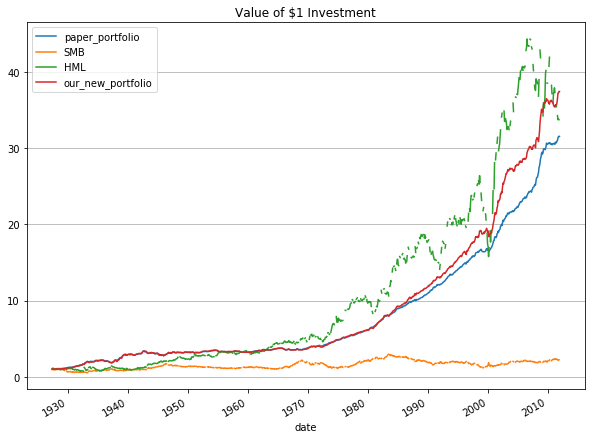

In [53]:
# Figure 1
portfolios = pd.DataFrame()
portfolios['cum_ew'] = (longshortport_eq['longshort_eq'] + 1).cumprod()
# print(portfolios['cum_ew'])
portfolios['cum_ew2'] = (longshortport_eq2['longshort_eq'] + 1).cumprod()
portfolios['SMB']= (ff4['smb']+ 1).cumprod()
portfolios['HML']= (ff4['hml']+ 1).cumprod()
portfolios=portfolios.reset_index()
portfolios
# Within-companies Predicted Dividend Portfolio
(
    portfolios
    .assign(date=pd.to_datetime(portfolios['date']))
    .assign(paper_portfolio=portfolios['cum_ew'])
    .assign(our_new_portfolio=portfolios['cum_ew2'])
    .assign(SMB=portfolios['SMB'])
    .assign(HML=portfolios['HML'])
    .plot(x='date', y=['paper_portfolio','SMB','HML','our_new_portfolio'],figsize=(10,7.5),title='Value of $1 Investment').grid(axis='y')
)